In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from communicative_agent import CommunicativeAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [3]:
ABX_NB_SAMPLES = 50
AGENT_ABX_DISTANCES = [
    {
        "sound_units": {
            "metric": "cosine",
            "weight": 1,
        }
    },
    {
        "art_units": {
            "metric": "cosine",
            "weight": 1,
        },
    }
]

In [6]:
agents_path = glob("../out/communicative_agent/*/")
agents_path.sort()

agents_alias = {}

for agent_path in agents_path:
    agent = CommunicativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
        
    agent_i = agent_path[-2] 
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"nd={config['model']['direct_model']['nb_derivatives']}",
        f"jerk={config['training']['jerk_loss_weight']}",
        f"({agent_i})",
    ))
    
    agents_alias[agent_alias] = agent_path

KeyError: 'names'

In [4]:
agents_abx_matrices = utils.pickle_load("../out/communicative_agent/abx_cache.pickle", {})
# agents_abx_matrices = {}

for agent_alias, agent_path in tqdm(agents_alias.items()):
    agent = CommunicativeAgent.reload(agent_path)
    
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES)
        
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/communicative_agent/abx_cache.pickle", agents_abx_matrices)

  0%|          | 0/10 [00:00<?, ?it/s]

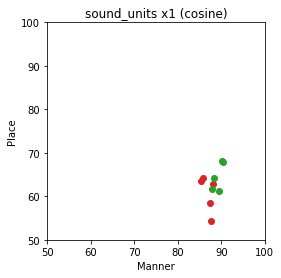

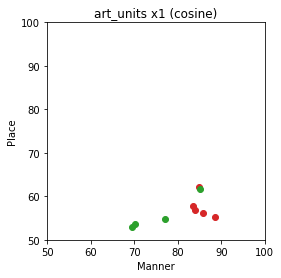

In [5]:
for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure()
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title(distance_signature)
    
    for agent_alias, agent_path in agents_alias.items():
        agent = CommunicativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()
        
        color = "tab:green" if agent.config["training"]["jerk_loss_weight"] > 0 else "tab:red"

        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, dataset.phones_infos["consonant_groups"])
        ax.scatter(agent_groups_score["manner"], agent_groups_score["place"], c=color)
        # raise
    
    plt.show()